In [1]:
import matplotlib

In [2]:
%matplotlib notebook

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy import wcs
from astropy.time import Time
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import EarthLocation, GCRS, CartesianRepresentation, AltAz, SkyCoord, ICRS

from reproject import reproject_interp

In [4]:
import ipywidgets as widgets
from ipywidgets import interact, interactive

In [5]:
from os.path import basename

In [6]:
import pandas as pd
from glob import glob
import warnings
from tqdm.autonotebook import tqdm
from shapely.geometry import LineString

<ipython-input-6-7f495fa06e00>:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [7]:
warnings.simplefilter('ignore', wcs.FITSFixedWarning)

In [8]:
def read_cams_observations(fname):
    # Read file
    d = np.loadtxt(fname,
                   skiprows=3,
                   usecols=(0, 1, 2, 3,
                            4, 5, 7, 9,
                            15, 17, 19, 21,
                            23, 25, 31, 32),
                   dtype={"names": ("number", "date", "time", "tbeg",
                                    "tend", "RAinf", "DECinf", "Vinf",
                                    "LatBeg", "LonBeg", "Hbeg", "LatEnd",
                                    "LonEnd", "Hend", "Max-mV", "Int-mV"),
                          "formats": ("i4", "S10", "S11", "f4",
                                      "f4", "f4", "f4", "f4",
                                      "f4", "f4", "f4", "f4",
                                      "f4", "f4", "f4", "f4")})

    # Convert time
    tstr = [f"{d.decode('UTF-8')}T{t.decode('UTF-8')}" for d, t in zip(d["date"], d["time"])]
    t = Time(tstr, format="isot", scale="utc")
    t0 = t + d["tbeg"] * u.s
    t1 = t + d["tend"] * u.s
    
    # Convert radiant and velocity
    vx = -d["Vinf"] * np.cos(d["DECinf"] * u.deg) * np.cos(d["RAinf"]  * u.deg) * u.km / u.s
    vy = -d["Vinf"] * np.cos(d["DECinf"] * u.deg) * np.sin(d["RAinf"]  * u.deg) * u.km / u.s
    vz = -d["Vinf"] * np.sin(d["DECinf"] * u.deg) * u.km / u.s

    # Convert positions
    x0, y0, z0 = EarthLocation(lat = d["LatBeg"] * u.deg,
                               lon = d["LonBeg"] * u.deg,
                               height = d["Hbeg"] * u.km).get_gcrs(obstime=t0).cartesian.xyz

    # Write out
    return Table([d["number"], t.isot, x0, y0, z0, vx, vy, vz, d["tbeg"], d["tend"]],
              names=["number", "t0", "x0", "y0", "z0", "vx", "vy", "vz", "dtmin", "dtmax"])

In [9]:
fitsfiles = sorted(glob("/data1/dijkema/A12_meteor/*.fits"))

In [10]:
fitstimes = Time([fitsfile[26:47] for fitsfile in fitsfiles], format='isot')

In [11]:
def get_fitsfiles(cams_time, extra=0, extra_before=0):
    """Get filenames of time just before CAMS time and the CAMS time itself"""
    index_with_cams_time = np.argmin(cams_time > fitstimes)
    index_with_detection = index_with_cams_time + extra # Can be tweaked, maybe -1 or +1
    index_before_detection = index_with_cams_time - 2 - extra_before # Can be tweaked, maybe -1
    assert((Time(fitsfiles[index_with_detection][26:47]) - Time(fitsfiles[index_before_detection][26:47])).to(u.s) < 16*u.s)
    return fitsfiles[index_before_detection], fitsfiles[index_with_detection]

In [12]:
# LOFAR location
loc_lofar = EarthLocation(lat = 52.9153 * u.deg,
                          lon = 6.8698 * u.deg,
                          height = 0 * u.m)

In [13]:
camsdata = pd.read_fwf("../SummaryMeteorLog CAMS Benelux 120820 .txt",
                            index_col=0,
                            header=[0, 1],
                            skip_blank_lines=True,
                            skiprows=[2],
                            skipinitialspace=True)

camsdata.columns = [
    ' '.join(col) if isinstance(col, tuple) else col
    for col in camsdata.columns
]

camsdata["astropytime_beg"] = Time(
    list(camsdata["Observed Date"] + " " + camsdata["Ref Time UT"])
) + np.array(camsdata["Tbeg sec"]) * u.s
camsdata["astropytime_end"] = Time(
    list(camsdata["Observed Date"] + " " + camsdata["Ref Time UT"])
) + np.array(camsdata["Tend sec"]) * u.s

camsdata = camsdata.join(pd.read_csv("aartfaac-cams-matches.csv", index_col=0))

camsdata = camsdata.join(pd.read_csv("radioheight_perseids.csv", index_col=0))

In [14]:
def get_height(g, x0, x1, x):
    """
    g is trail of meteor in GCRS
    x0 is x coordinate of start in pixels
    x1 is x coordinate of end in pixels
    x is clicked coordinate in pixels
    
    Returns:
        height above WGS84 (as quantity)
    """
    xyz_beg = g.cartesian.xyz[:,0,0]
    xyz_end = g.cartesian.xyz[:,-1,0]
    xyz_interp = xyz_beg + (xyz_end-xyz_beg) * (x-x0)/(x1-x0)
    g_interp = EarthLocation(*xyz_interp)
    return g_interp.height

In [15]:
d_all = read_cams_observations("../SummaryMeteorLog CAMS Benelux 120820 .txt")

In [16]:
def reproject_image(fitsfile_before_detection, fitsfile_with_detection, cams_number, nx, ny):
    """
    Returns:
       image_reprojected, (meteor_pixels_x, meteor_pixels_y)
    """    
    d = d_all[d_all["number"] == cams_number]
    assert(len(d) == 1)
    
    hdu = fits.open(fitsfile_with_detection)
    data = np.squeeze(hdu[0].data)
    header = hdu[0].header
    hdu.close()

    hdu = fits.open(fitsfile_before_detection)
    data = data - np.squeeze(hdu[0].data)
    hdu.close()

    # Construct trajectory
    dt = np.linspace(d["dtmin"], d["dtmax"], 10)
    x, y, z = d["x0"] + dt * d["vx"], d["y0"] + dt * d["vy"], d["z0"] + dt * d["vz"]
    trajectory_xyz = GCRS(CartesianRepresentation(x=x * u.km, y=y * u.km, z=z * u.km), obstime=d['t0'])

    # Observe from LOFAR
    obsgeoloc, obsgeovel = loc_lofar.get_gcrs_posvel(obstime=d['t0'])
    glofar = trajectory_xyz.transform_to(GCRS(obstime=d['t0'], obsgeoloc=obsgeoloc, obsgeovel=obsgeovel))
    p = SkyCoord(ra=glofar.ra.degree, dec=glofar.dec.degree, unit="deg")

    # Get extrema
    pmin, pmax, pmid = p[0].squeeze(), p[-1].squeeze(), p[len(p) // 2].squeeze()

    # Rotation angle
    ang = pmin.position_angle(pmax) - 90 * u.deg
    # print(ang.to(u.deg))

    # Data WCS
    oldwcs = wcs.WCS(header, naxis=2)

    # Generate new WCS
    wnew = wcs.WCS(naxis=2)
    wnew.wcs.crval = np.array([pmid.ra.degree, pmid.dec.degree])
    wnew.wcs.crpix = np.array([nx / 2, ny / 2])
    wnew.wcs.cdelt = np.array([0.1, 0.1])
    wnew.wcs.pc = np.array([[np.cos(ang), np.sin(ang)],
                            [-np.sin(ang), np.cos(ang)]])
    wnew.wcs.ctype = ["RA---STG", "DEC--STG"]    

    # Reproject meteor
    v, footprint = reproject_interp((data, oldwcs), wnew, shape_out=(ny, nx))
    
    return v, p.to_pixel(wnew), trajectory_xyz

In [17]:
def show_figure(number, extra, extra_before):
    plt.close('all')
    
    d = d_all[d_all["number"] == number]
    t0 = Time(d["t0"], format="isot", scale="utc")

    try:
        fitsfile_before_detection, fitsfile_with_detection = get_fitsfiles(t0[0], extra, extra_before)
    except:
        print("No good times around", t0)
        return
    
    if len(d) != 1:
        print("No match for cams number", number)
        return
    
    v, (x, y), trajectory_xyz = reproject_image(fitsfile_before_detection, fitsfile_with_detection, number, 500, 61)

    vmin = np.nanmean(v) - 2 * np.nanstd(v)
    vmax = np.nanmean(v) + 4 * np.nanstd(v)

    fig, ax = plt.subplots(1, figsize=(8, 2))

    ax.imshow(v, origin="lower", interpolation="None",
              vmin=vmin, vmax=vmax)

    ax.plot(x[0], y[0], "rx", alpha=0.9)
    ax.plot(*(LineString(np.array([x.flatten(), y.flatten()]).T).buffer(10).exterior.xy), color="red", alpha=0.9)

    ax.text(x[0], 0, camsdata.loc[number]["Hbeg km"],verticalalignment='top', horizontalalignment='center')
    
    ax.text(x[-1], 0, camsdata.loc[number]["Hend km"],verticalalignment='top', horizontalalignment='center')

    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_title(f"#{number} ({t0[0]}), duration={camsdata.loc[number]['AARTFAAC_duration']:.0f}, type {camsdata.loc[number]['AARTFAAC']:.0f}")
    
    camsdata.loc[number, "x0"] = x[0]
    camsdata.loc[number, "x1"] = x[-1]
    
    def onclick(event):
        height = get_height(trajectory_xyz, x[0], x[-1], event.xdata)
        if event.button == 3: # right click, end
            camsdata.loc[number, "xend"] = event.xdata
            camsdata.loc[number, "fitsfile_with_detection_end"] = basename(fitsfile_with_detection)
            camsdata.loc[number, "hend_radio"] = (height.to(u.km)).value
        else: # single click: begin
            camsdata.loc[number, "xbeg"] = event.xdata
            camsdata.loc[number, "fitsfile_with_detection_beg"] = basename(fitsfile_with_detection)
            camsdata.loc[number, "hbeg_radio"] = (height.to(u.km)).value
        camsdata["fitsfile_before_detection"] = basename(fitsfile_before_detection)

    cid = fig.canvas.mpl_connect('button_press_event', onclick)
    
    plt.show();

In [18]:
cams_numbers = list(camsdata[np.logical_and(camsdata['AARTFAAC'] == 0, camsdata["hbeg_radio"].isnull())].index)

In [19]:
interactive_plot = interactive(show_figure, number=cams_numbers,
                               extra=widgets.IntSlider(min=-2, max=5, step=1, value=0),
                               extra_before=widgets.IntSlider(min=0, max=5, step=1, value=0))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(Dropdown(description='number', options=(49, 51, 53, 55, 56, 61, 62, 63, 64, 67, 68, 69, …

In [22]:
camsdata_annotated = camsdata.loc[camsdata["hbeg_radio"] > 0]
camsdata_annotated = camsdata_annotated[camsdata_annotated['hbeg_radio'] > camsdata_annotated['hend_radio']]
camsdata_annotated

,Observed Date,Ref Time UT,Tbeg sec,Tend sec,RAinf deg,+/- sigma,DECinf deg,+/- sigma.1,Vinf km/sec,+/- sigma.2,...,AARTFAAC,AARTFAAC_duration,x0,x1,xbeg,xend,hbeg_radio,hend_radio,fitsfile_with_detection_beg,fitsfile_with_detection_end
50,2020-08-12,21:07:28.10,0.00,0.72,279.84,0.10,26.32,0.17,19.58,0.13,...,2.0,2.0,223.725909,270.027125,229.379022,258.411280,91.587489,83.715641,2020-08-12T21:07:28.4_16B.fits,2020-08-12T21:07:28.4_16B.fits
52,2020-08-12,21:08:02.72,0.00,0.73,44.64,0.00,59.28,0.00,59.73,0.00,...,1.0,42.0,214.888671,274.173003,230.991926,253.572571,106.236453,98.000416,2020-08-12T21:08:04.6_15B.fits,2020-08-12T21:08:04.6_15B.fits
54,2020-08-12,21:12:12.94,-0.04,0.40,46.99,0.34,57.81,0.33,60.24,0.15,...,1.0,6.0,226.557392,266.322701,247.927410,287.443539,100.710988,88.105772,2020-08-12T21:12:14.2_13B.fits,2020-08-12T21:12:14.2_13B.fits
57,2020-08-12,21:12:45.23,0.00,0.69,48.97,0.07,57.62,0.02,61.15,0.03,...,2.0,14.0,200.654579,283.896183,227.766119,282.604829,105.199097,92.100635,2020-08-12T21:12:46.5_15B.fits,2020-08-12T21:12:48.5_15B.fits
58,2020-08-12,21:12:45.36,0.00,0.43,48.76,0.14,57.00,0.07,59.95,0.12,...,2.0,14.0,220.100330,270.717965,233.411280,293.088700,106.216724,92.107319,2020-08-12T21:12:46.5_15B.fits,2020-08-12T21:12:50.5_16B.fits
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
731,2020-08-13,03:20:15.16,0.00,0.25,47.84,0.10,58.23,0.08,63.21,0.12,...,1.0,2.0,229.282981,264.863622,253.572571,263.249990,98.638417,94.582204,2020-08-13T03:20:16.2_16B.fits,2020-08-13T03:20:16.2_16B.fits
732,2020-08-13,03:21:07.47,-0.03,0.41,47.60,0.10,59.08,0.06,59.35,0.13,...,2.0,72.0,208.461815,288.463767,248.733861,285.024184,101.583266,90.277967,2020-08-13T03:21:17.6_15B.fits,2020-08-13T03:21:17.6_15B.fits
735,2020-08-13,03:25:16.03,0.00,0.34,47.01,0.13,58.27,0.06,61.47,0.15,...,1.0,36.0,226.830822,266.784465,241.475797,269.701603,103.651175,89.662307,2020-08-13T03:25:14.2_14B.fits,2020-08-13T03:25:20.2_14B.fits
736,2020-08-13,03:27:09.95,-0.06,0.22,48.66,0.02,55.79,0.00,61.21,0.02,...,1.0,6.0,233.682117,261.247667,254.379022,272.120958,99.686068,89.294263,2020-08-13T03:27:09.9_16B.fits,2020-08-13T03:27:09.9_16B.fits


In [25]:
camsdata_annotated[['x0','x1','xbeg','xend','hbeg_radio',
                    'hend_radio','fitsfile_with_detection_beg',
                    'fitsfile_with_detection_end']].to_csv("radioheight_perseids.csv", float_format='%.3f',
                                                          index_label="camsid")

<IPython.core.display.Javascript object>


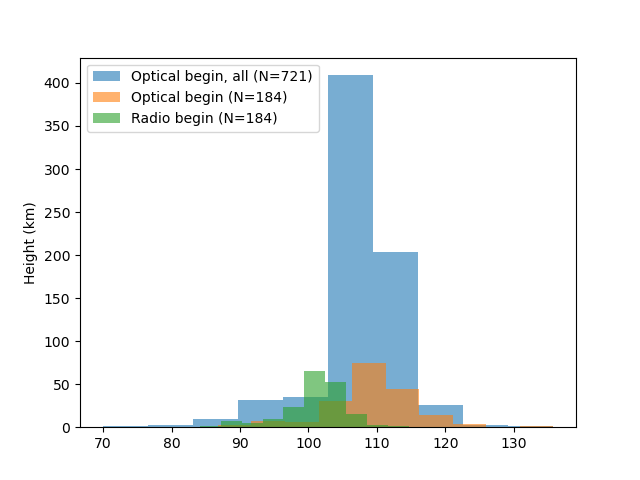

In [26]:
plt.close('all')
fig, ax = plt.subplots()
ax.hist(camsdata['Hbeg km'], alpha=0.6, label=f'Optical begin, all (N={len(camsdata)})');
ax.hist(camsdata_annotated['Hbeg km'], alpha=0.6, label=f'Optical begin (N={len(camsdata_annotated)})');
ax.hist(camsdata_annotated['hbeg_radio'], alpha=0.6, label=f'Radio begin (N={len(camsdata_annotated)})')
ax.set_ylabel("Height (km)")
ax.legend();
fig.savefig("begin_height.pdf")

<IPython.core.display.Javascript object>


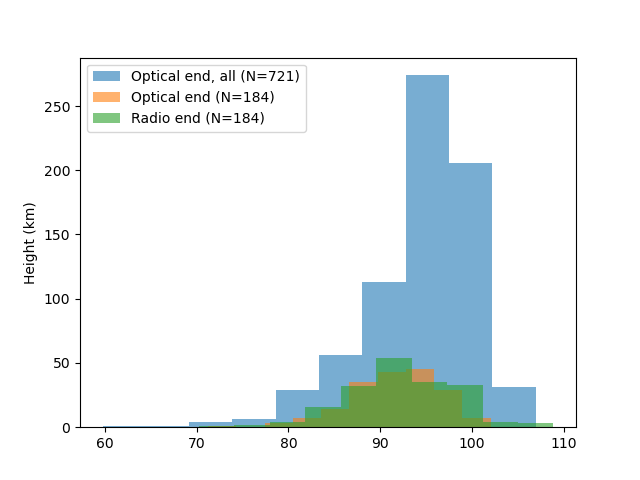

In [27]:
plt.close('all')
fig, ax = plt.subplots()
ax.hist(camsdata['Hend km'], alpha=0.6, label=f'Optical end, all (N={len(camsdata)})');
ax.hist(camsdata_annotated['Hend km'], alpha=0.6, label=f'Optical end (N={len(camsdata_annotated)})');
ax.hist(camsdata_annotated['hend_radio'], alpha=0.6, label=f'Radio end (N={len(camsdata_annotated)})')
ax.set_ylabel("Height (km)")
ax.legend();
fig.savefig("end_height.pdf");

<IPython.core.display.Javascript object>


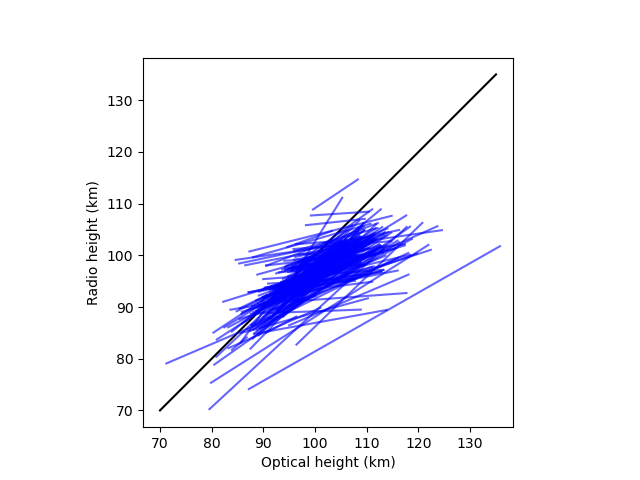

In [28]:
plt.close('all')
fig, ax = plt.subplots()
ax.plot([70, 135], [70, 135], color='k')
for rownr, row in camsdata_annotated.iterrows():
    ax.plot([row['Hbeg km'], row['Hend km']], [row['hbeg_radio'], row['hend_radio']], color='blue', alpha=0.6)
ax.set_xlabel("Optical height (km)")
ax.set_ylabel("Radio height (km)")
ax.set_aspect("equal")
ax.set_xlim(ax.get_ylim())
fig.savefig("radio-optical-trails.pdf")
plt.show()